In [1]:
# Import statements
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import openpyxl
import pylab as plt

import nltk

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
from wordcloud import WordCloud
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

from sentence_transformers import SentenceTransformer
import torch

import regex as re
import pandas as pd

# UBC Salaries Across Gender, Department, and Job Title

## Introduction

The primary goal of this project is to gain experience in data wrangling, machine learning, and Tableau. My secondary goal is to visualize the University of British Columbia (UBC) faculty salaries across gender, department, and job title. The visualization will be in the form of a Tableau dashboard. 

As hinted at above, for this project I am prioritizing learning over accuracy of results. Therefore, rather than taking the straightforward route of requesting salary data from UBC by faculty and gender, I will only use the pdf of salary data published annually by UBC, UBC's faculty directory, and global baby name datasets. This approach includes tasks such as scraping, clustering, and transforming data. It allows for a deeper dive into data manipulation techniques, fostering a comprehensive understanding of the complexities in data wrangling.

## Contents

The following list is how the rest of this project will unfold:

- Data Collection and Cleaning
    - Salary Data
    - Department and Job Title Data
- Gender Prediction
- Data Visualization
- Conclusion

## Data Collection and Cleaning

### Salary Data

We can use the PDF salary information that UBC releases every year. To do this, go to the following link: [UBC Financial Reports](https://finance.ubc.ca/reporting-planning-analysis/financial-reports), open the most recent Financial Information Act Report, and click Control + A to copy the contents of the pdf. Paste the contents into a text file and then upload the file blow. The data used for this analysis is from the Financial Information Act Report of 2022.

In [2]:
# Import UBC salary text file
raw_data = open("data/UBC Staff Salary.txt","r").read()


Now, we will clean up this data so it can be formatted in a pandas DataFrame with four columns, `First Name`, `Last Name`, `Remuneration`, and `Expenses`. Them we export the dataframe to an excel sheet.

In [3]:

# Remove beginning/end text
raw_data_a = raw_data.split('Earnings greater than')[0].split('external cost recoveries.')[1]

# Remove unnessessary lines
raw_data_b = re.split('([\.\p{L},\s-]+[\s\n]+[0-9,-]+[\s\n]+[0-9,-]+)', raw_data_a)

raw_data_c = [i for i in raw_data_b if (',' in i) and ('SCHEDULE' not in i)]

# Remove spaces and new lines
raw_data_d = [i.replace('\n',' ').strip() for i in raw_data_c]

# Split data into Names/Remuneration/Expenses
raw_data_e = [i.rsplit(' ',2) for i in raw_data_d]

# Create Column names
ubc_salary_data = pd.DataFrame(raw_data_e, columns = ['Name', 'Remuneration', 'Expenses'])

# Split Name into First/Last Name
ubc_salary_data[['Last Name','First Name']] = ubc_salary_data['Name'].str.split(', ', expand= True)

# Select necessary columns
ubc_salary_data = ubc_salary_data[['Last Name','First Name','Remuneration','Expenses']]

# turn salary column from string to numeric
ubc_salary_data['Remuneration'] = ubc_salary_data['Remuneration'].astype(str).str.replace(',','').astype(float)

# Export DataFrame
ubc_salary_data.to_excel('data/UBC_Salary_DF.xlsx')

ubc_salary_data.head()

,Last Name,First Name,Remuneration,Expenses
0,Aamodt,Tor,221891.0,"1,901"
1,Abanto Salguero,Arleni Karina,100614.0,550
2,Abbassi,Arash,107289.0,104
3,Abdalkhani,Arman,75319.0,-
4,Abdelaziz,Morad,117078.0,"3,549"


### Department and Job Title Data

#### Collection

I got department and job title information for each UBC staff member from the following [website](https://directory.ubc.ca/index.cfm). The code and entirety of the raw data will not be included here because it is forbidden to publicly distribute all of this data. To gather the data I used Python's requests package.

In [4]:
# Read in combined salary and department data.
pop_df = pd.read_excel('/Users/jadebouchard/PycharmProjects/UBCSalaries/data/UBC_Salary_Department.xlsx', index_col = 0)

In [5]:
pop_df.head()

,Unnamed: 0,Last Name,First Name,Remuneration,Expenses,Title/Department
0,0,Aamodt,Tor,"221,891","1,901","['Professor', 'Electrical and Computer Enginee..."
1,1,Abanto Salguero,Arleni Karina,"100,614",550,[]
2,2,Abbassi,Arash,"107,289",104,"['Intern, Strategy and Decision Support', 'Off..."
3,3,Abdalkhani,Arman,"75,319",-,"['Clinical Instructor, Otolaryngology - Head a..."
4,4,Abdelaziz,Morad,"117,078","3,549","['Assistant Professor', 'School of Engineering..."


#### Cleaning

##### Separating Title and Department

Clearly the Title/Department Column needs some cleaning up. The first step will be to split the Title/Department column into two new columns. 

In [6]:
def str_to_list(str):
    '''turn string-list into an actual list'''
    list = str.replace("'","").replace('[','').replace(']','').split(',')
    return list

def concatenate_departments(scraped_list):
    '''take a list of strings, find the department-strings (2nd string onwards), and turn them into one string'''
    department_str = ''
    for department in scraped_list[1:]:
        department_str = department_str + ' ' + department
    return department_str.strip()

def return_department(scraped_str):
    '''extract department info from a string of department/job title info'''
    scraped_list = str_to_list(scraped_str)
    if len(scraped_list) == 1: # if only one item scraped, assume it is the department
        return scraped_list[0]
    elif len(scraped_list) > 1: # if more than one item scraped, return the 2nd item onwards as a concatenated string
        return concatenate_departments(scraped_list)
    else:
        return ''

def return_job_title(scraped_str):
    '''extract job title info from a string of department/job title info'''
    scraped_list = str_to_list(scraped_str)
    if len(scraped_list) > 1: # if more than one item scraped, assume the first one is the job title
        return scraped_list[0]
    else:
        return ''

In [7]:
pop_df_dep = pop_df.copy()
pop_df_dep['Department'] = pop_df_dep['Title/Department'].apply(return_department) # add department column
pop_df_dep['Title'] = pop_df_dep['Title/Department'].apply(return_job_title) # add job title column
pop_df_dep.head()

,Unnamed: 0,Last Name,First Name,Remuneration,Expenses,Title/Department,Department,Title
0,0,Aamodt,Tor,"221,891","1,901","['Professor', 'Electrical and Computer Enginee...",Electrical and Computer Engineering,Professor
1,1,Abanto Salguero,Arleni Karina,"100,614",550,[],,
2,2,Abbassi,Arash,"107,289",104,"['Intern, Strategy and Decision Support', 'Off...",Strategy and Decision Support Office of the V...,Intern
3,3,Abdalkhani,Arman,"75,319",-,"['Clinical Instructor, Otolaryngology - Head a...",Otolaryngology - Head and Neck Surgery Associ...,Clinical Instructor
4,4,Abdelaziz,Morad,"117,078","3,549","['Assistant Professor', 'School of Engineering...",School of Engineering - UBC Okanagan,Assistant Professor


In [8]:
pop_df_dep['Department'].nunique()

1922

In [9]:
pop_df_dep['Title'].nunique()

1658

Now, the department and title information is separated. However, there are so many unique values that it will make data analysis difficult and ineffective. Therefore, I will group together similar department data and title data.

##### Grouping Data

For clustering Department I used the DBScan clustering method. I chose this method over KMeans as it allows for points to not have an assigned Department. It also lets me avoid choosing the number of groups beforehand. I chose a fairly conservative eps value (0.25) as it's important that points don't get miss-classified.

The first step is to do some preprocessing. I will remove some words and symbols from the department column that I don't want the algorithm using to determine similarity.

In [10]:
# Removing some words and symbols from the department text as it confuses the cluster algorithm
pop_df_dep["Department"] = pop_df_dep["Department"].replace({"Faculty of ":"",
                                                             "Faculty":"",
                                                             "IKBFoS":"", "IKBFASS":"", 
                                                             "–":"", "-":"", "Department":"", "School":"",
                                                             "Office":"","Institute":""}, regex=True)

I'm also choosing to remove Location info about university, although it would be interesting to look at salary disparity across location another time

In [11]:
pop_df_dep["Department"] = pop_df_dep["Department"].replace({"UBC Okanagan":""}, regex=True)

The next step is to train the clustering model.

In [12]:
embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [13]:
emb_department = embedder.encode(pop_df_dep['Department'])

In [14]:
emb_department_df = pd.DataFrame(emb_department, index=pop_df_dep.index)

In [15]:
dbscan = DBSCAN(eps=0.23, min_samples = 20,metric='cosine')
dbscan.fit(emb_department_df)

/Users/jadebouchard/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


DBSCAN(eps=0.23, metric='cosine', min_samples=20)

Now that we have our model fitted, we can analyze its performance. To do this, I create and examine a silhouette plot. 

In [16]:
n_clusters = len(set(dbscan.labels_))
dbscan.n_clusters = n_clusters
dbscan.predict = lambda x: dbscan.labels_

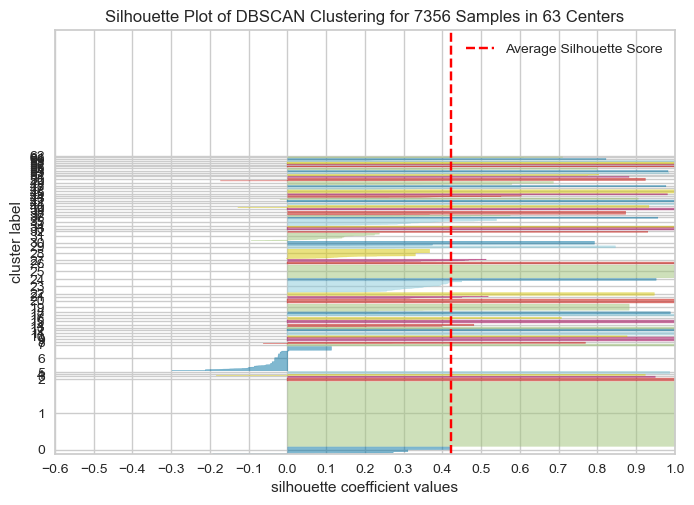

<Axes: title={'center': 'Silhouette Plot of DBSCAN Clustering for 7356 Samples in 63 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
visualizer = SilhouetteVisualizer(dbscan, colors="yellowbrick")
visualizer.fit(emb_department)  
visualizer.show()

From the above silhouette plot, I can see that that the chosen eps and min_sample values do a pretty good job of seperating the data into distinct clusters. 

One item of note is that the 1 cluster (data points with a null Department value) makes up about 20% of the data. This informs us that many observations do not have an associated department in the data, therefore conclusions based of the data may not accurately represent the entire population of UBC faculty.

Also, cluster 6 (the "medicine" cluster) seems to have many negative values, indicating some departments in that category may be similar to other clusters than just 6. After further investigation, cluster 6 seems to contain observations that should be grouped together. Therefore, I will carry on using the clusters created.

In [18]:
len(set(dbscan.labels_))

63

In [19]:
pop_df_dep["reduced_department"] = dbscan.labels_

The code above has assigned 62 unique labels to the observations. Each label is currently represented by a number which is not very interpretable. Below I will find the most common word(s) for each label and use that string to represent the label.

In [20]:
pop_df_dep["reduced_department"] = pop_df_dep["reduced_department"].astype(str) # turn column to type string
for cluster_num in range(-1,len(set(dbscan.labels_))-1): # for each label:
    cluster = pop_df_dep[pop_df_dep["reduced_department"] == str(cluster_num)] # filter data for label
    name_string = ' '.join(cluster["Department"].tolist()) # create long string of all words in label
    if cluster_num == -1:
            pop_df_dep.loc[pop_df_dep["reduced_department"] == str(cluster_num), "reduced_department"] = np.nan
    elif name_string.strip():
        wordcloud = WordCloud().generate(name_string) # find the commonality of words
        str_label = list((wordcloud.words_.keys()))[0] # select the most common word(s)
        # rename label with common word(s)
        pop_df_dep.loc[pop_df_dep["reduced_department"] == str(cluster_num), "reduced_department"] = str_label 

# give unlabeled data-points the label np.nan
pop_df_dep["reduced_department"] = pop_df_dep["reduced_department"].replace({"1":np.nan}, regex=True) 
pop_df_dep.head(7)

,Unnamed: 0,Last Name,First Name,Remuneration,Expenses,Title/Department,Department,Title,reduced_department
0,0,Aamodt,Tor,"221,891","1,901","['Professor', 'Electrical and Computer Enginee...",Electrical and Computer Engineering,Professor,Computer Engineering
1,1,Abanto Salguero,Arleni Karina,"100,614",550,[],,,NaN
2,2,Abbassi,Arash,"107,289",104,"['Intern, Strategy and Decision Support', 'Off...",Strategy and Decision Support of the VicePre...,Intern,NaN
3,3,Abdalkhani,Arman,"75,319",-,"['Clinical Instructor, Otolaryngology - Head a...",Otolaryngology Head and Neck Surgery Associa...,Clinical Instructor,NaN
4,4,Abdelaziz,Morad,"117,078","3,549","['Assistant Professor', 'School of Engineering...",of Engineering,Assistant Professor,Engineering
5,5,Abdelpakey,Mohamed,"79,281",-,[],,,NaN
6,6,Abdi,Ali,"241,966",729,"['Professor', 'Educational Studies (EDST)']",Educational Studies (EDST),Professor,Educational Studies


Now the labels of the data points are more interpretable. Below we can see all of the unique labels. This list of unique labels was useful when deciding which words to remove from the data, such as "Faculty of".

In [21]:
pop_df_dep["reduced_department"].unique()

array(['Computer Engineering', nan, 'Engineering', 'Educational Studies',
       'Materials Engineering', 'Asian Studies', 'Medicine', 'Sociology',
       'Literacy Education', 'Computer Science', 'Statistics', 'Library',
       'Botany', 'Enrolment Services', 'Civil Engineering',
       'Cultural Studies', 'Pharmaceutical Sciences', 'English Language',
       'Pedagogy EDCP', 'Economics Vancouver', 'Building Operations',
       'Nursing', 'Stewart Blusson', 'Alumni Engagement', 'Law Allard',
       'Business University', 'Service Centre', 'Information Technology',
       'Dentistry', 'Forestry Forest', 'Teaching Learning',
       'Psychology Psychology', 'Services Facilities', 'Human Early',
       'Chemistry', 'Political Science', 'Obstetrics Gynaecology',
       'International Student', 'UBC Vantage', 'Earth Ocean', 'Forestry',
       'Zoology Zoology', 'French Hispanic', 'Astronomy Physics',
       'Family Practice', 'VicePresident Research', 'Film Theatre',
       'Mathematics', '

We can see that some of these labels need adjustments. Below, I manually alter the labels for interpretability and to further combine some groups.

In [22]:
pop_df_dep["reduced_department"] = pop_df_dep["reduced_department"].replace({"Computer Engineering":"Engineering", 
                                                                   "Educational Studies":"Education",
                                                                   "Literacy Education":"Literacy",
                                                                   "Enrolment Services":"Enrolment",
                                                                   "Materials Engineering":"Engineering", 
                                                                   "Business University":"Sauder",
                                                                   "Sociology Department":"Sociology",
                                                                   "Economics Vancouver":"Economics",
                                                                   "Family Practice":"Medicine",
                                                                   "Vancouver School":"Economics",
                                                                   "UBC Vantage":"Vantage College",
                                                                   "Civil Engineering":"Engineering",
                                                                   "Stewart Blusson":"Physics/Astronomy",
                                                                   "Law Allard":"Law",
                                                                   "Services Facilities":"Facility Services",
                                                                   "Sauder School":"Sauder",
                                                                   "English Language":"English",
                                                                   "Service Centre":"Integrated Service Centre",
                                                                   "Forestry Forest":"Forestry",
                                                                   "Teaching Learning":"Teaching",
                                                                   "Health Social":"Health & Social Development",
                                                                   "Psychology Psychology":"Psychology",
                                                                   "Human Early":"Early Learning",
                                                                   "Obstetrics Gynaecology":"Obstetrics & Gynaecology",
                                                                   "International Student":"International Student Initiative/Development",
                                                                   "Earth Ocean":"Earth/Ocean/Atmospheric Sciences",
                                                                   "Media School": "Journalism",
                                                                   "Zoology Zoology":"Zoology",
                                                                   "French Hispanic":"Language Studies",
                                                                   "Astronomy Physics":"Physics and Astronomy",
                                                                   "VicePresident Research": "Research & Innovation",
                                                                   "Film Theatre":"Theatre and Film",
                                                                   "Vancouver Coastal":"Surgery Medicine",
                                                                   "Geography Geography":"Geography",
                                                                   "Food Systems":"Land and Food Systems",
                                                                   "Surgery Medicine":"Surgery",
                                                                   "Special Education":"Counselling and Special Education",
                                                                   "Economics Philosophy": "Philosophy",
                                                                   "Digital Solutions":"Digital Solutions Medicine",
                                                                   "Pharmacology Therapeutics":"Pharmacology",
                                                                   "Pharmaceutical Sciences":"Pharmacology",          
                                                                  }
                                                                  , regex=True)

In [23]:
pop_df_dep["reduced_department"].unique()

array(['Engineering', nan, 'Education', 'Asian Studies', 'Medicine',
       'Sociology', 'Literacy', 'Computer Science', 'Statistics',
       'Library', 'Botany', 'Enrolment', 'Cultural Studies',
       'Pharmacology', 'English', 'Pedagogy EDCP', 'Economics',
       'Building Operations', 'Nursing', 'Physics/Astronomy',
       'Alumni Engagement', 'Law', 'Sauder', 'Integrated Service Centre',
       'Information Technology', 'Dentistry', 'Forestry', 'Teaching',
       'Psychology', 'Facility Services', 'Early Learning', 'Chemistry',
       'Political Science', 'Obstetrics & Gynaecology',
       'International Student Initiative/Development', 'Vantage College',
       'Earth/Ocean/Atmospheric Sciences', 'Zoology', 'Language Studies',
       'Physics and Astronomy', 'Research & Innovation',
       'Theatre and Film', 'Mathematics', 'Surgery Medicine', 'Geography',
       'Land and Food Systems', 'Human Resources', 'Recreation Athletics',
       'Architecture', 'Kinesiology', 'Counselling

In [24]:
pop_df_dep.head()

,Unnamed: 0,Last Name,First Name,Remuneration,Expenses,Title/Department,Department,Title,reduced_department
0,0,Aamodt,Tor,"221,891","1,901","['Professor', 'Electrical and Computer Enginee...",Electrical and Computer Engineering,Professor,Engineering
1,1,Abanto Salguero,Arleni Karina,"100,614",550,[],,,NaN
2,2,Abbassi,Arash,"107,289",104,"['Intern, Strategy and Decision Support', 'Off...",Strategy and Decision Support of the VicePre...,Intern,NaN
3,3,Abdalkhani,Arman,"75,319",-,"['Clinical Instructor, Otolaryngology - Head a...",Otolaryngology Head and Neck Surgery Associa...,Clinical Instructor,NaN
4,4,Abdelaziz,Morad,"117,078","3,549","['Assistant Professor', 'School of Engineering...",of Engineering,Assistant Professor,Engineering


There are now cleaned, grouped departments for our data.

Now for clustering the job titles. Instead of using DBscan, I created my own grouping method as DBscan wasn't quite capturing the groups for title that I had in mind.

In [25]:
pop_df_dep['Reduced Title'] = '' # create new column for reduced title
pop_df_dep['Title'] = pop_df_dep['Title'].str.title() # make sure Title column is in title case

def reduce_title_or(df, str_list):
    ''' if the title contains a string in the string list, reduce the title to that string'''
    for reduced_str in str_list:
        df.loc[df['Title'].str.contains(reduced_str), 'Reduced Title'] = reduced_str
    return df


pop_df_dep = reduce_title_or(pop_df_dep, ['Professor','Director','Research','Manager','Instructor','Lecturer',
                                          'Adivsor','Librarian','Analyst','Intern','Admin','Lead',
                                         'Coordinator','Writer','Architect','Officer'])

pop_df_dep['Reduced Title'] = pop_df_dep['Reduced Title'].replace('',np.nan)
pop_df_dep.head()

,Unnamed: 0,Last Name,First Name,Remuneration,Expenses,Title/Department,Department,Title,reduced_department,Reduced Title
0,0,Aamodt,Tor,"221,891","1,901","['Professor', 'Electrical and Computer Enginee...",Electrical and Computer Engineering,Professor,Engineering,Professor
1,1,Abanto Salguero,Arleni Karina,"100,614",550,[],,,NaN,NaN
2,2,Abbassi,Arash,"107,289",104,"['Intern, Strategy and Decision Support', 'Off...",Strategy and Decision Support of the VicePre...,Intern,NaN,Intern
3,3,Abdalkhani,Arman,"75,319",-,"['Clinical Instructor, Otolaryngology - Head a...",Otolaryngology Head and Neck Surgery Associa...,Clinical Instructor,NaN,Instructor
4,4,Abdelaziz,Morad,"117,078","3,549","['Assistant Professor', 'School of Engineering...",of Engineering,Assistant Professor,Engineering,Professor


Now we have cleaned data for title and department columns for each observation. The next step will be to predict gender data for each observation.

## Predicting Gender

Including gender data will allow for an interesting analysis of salary separated by gender. There is a well known pay gap between male and female employees around the world so it will be interesting to see if this gap shows up in the UBC faculty population as well. As mentioned in the introduction, requesting gender data from UBC would create the most accurate dataset. Instead, in order to practice natural language processing and data wrangling, I will attempt to predict gender values based on global gender data. Since these predictions may not be accurate, it is important to be skeptical of any hard conclusions drawn from analysis on this data.

### Using corpus

The easiest and quickest way to estimate the gender of the UBC faculty without asking UBC for the information is probably to a corpus with names and genders. Then for each name, I find whether there are more associated girl or guy names and the result will be the predicted gender.

First, I will read in Canadian baby name data.

In [26]:
# Read in canadian data we will use to train our model
# Data from statcan - https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710014701
# Includes baby name data (name, sex at birth) for babies from 1991 to 2021
canadian_names = pd.read_csv('data/17100147.csv')
canadian_names['First name at birth'] = [i.split(' ')[0] for i in canadian_names['First name at birth']]
canadian_names.head()

,REF_DATE,GEO,DGUID,Sex at birth,First name at birth,Indicator,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1991,Canada,2021A000011124,Male,AARON,Frequency,Number,223,units,0,v1491674946,1.1.73.1,1049.0000,NaN,NaN,NaN,0
1,1991,Canada,2021A000011124,Male,AARON,Rank,Number,223,units,0,v1491690733,1.1.73.2,45.0000,NaN,NaN,NaN,0
2,1991,Canada,2021A000011124,Male,AARON,Proportion (%),Percent,239,units,0,v1491706520,1.1.73.3,0.5442,NaN,NaN,NaN,4
3,1991,Canada,2021A000011124,Male,ABBAS,Frequency,Number,223,units,0,v1491674988,1.1.115.1,8.0000,NaN,NaN,NaN,0
4,1991,Canada,2021A000011124,Male,ABBAS,Rank,Number,223,units,0,v1491690775,1.1.115.2,1276.0000,NaN,NaN,NaN,0


Then, I will find the total number of baby names split by sex and name (VALUE), as well as the total number of baby names just split by name (TOTAL VALUE).  

In [27]:
def find_totals(df):
    '''add column with total counts across name'''
    # Find the total count of male + female for each baby name
    totals = df[['First name at birth','VALUE']].groupby(['First name at birth']).sum().reset_index().rename(columns = {'VALUE':'TOTAL VALUE'})
    # Merge the total count with the rest of the baby name data
    df = pd.merge(df, totals, on = 'First name at birth', how = 'left')
    return df

In [28]:
# Group by baby name and sum frequency counts over the years, remove unnecessary features
canadian_names = canadian_names.query("Indicator == 'Frequency'")[['Sex at birth', 'First name at birth','VALUE']].groupby(['Sex at birth', 'First name at birth']).sum().reset_index()
# Find the total count of male + female for each baby name
canadian_names = find_totals(canadian_names)
canadian_names.head()

,Sex at birth,First name at birth,VALUE,TOTAL VALUE
0,Female,AADHIRA,32.0,32.0
1,Female,AADHYA,223.0,223.0
2,Female,AADYA,148.0,148.0
3,Female,AAFIYA,11.0,11.0
4,Female,AAFIYAH,5.0,5.0


Now, I will complete the same process with an american baby name dataset, making sure the american data is in the same format as the Canadian data.

In [29]:
# Read in extra data for american names and clean it up so that it can be merged with other training data
# https://www.kaggle.com/datasets/kaggle/us-baby-names/code
american_names = pd.read_csv("data/NationalNames.csv")
# If there are multiple names, just keep the first one
american_names['Name'] = [i.split(' ')[0] for i in american_names['Name']]
# Rename columns to match Canadian data
american_names = american_names.rename(columns = {'Name':'First name at birth', 'Gender':'Sex at birth','Count':'VALUE'})
# Relabel sex data to match Canadian data
american_names['Sex at birth'] = american_names['Sex at birth'].replace({'F':'Female','M':'Male'})

# Find counts for each name/gender combo over the years
american_names = american_names[['Sex at birth', 'First name at birth','VALUE']].groupby(['Sex at birth', 'First name at birth']).sum().reset_index()
# Find total for each name across gender
american_names = find_totals(american_names)
american_names.head()

,Sex at birth,First name at birth,VALUE,TOTAL VALUE
0,Female,Aabha,21,21
1,Female,Aabriella,10,10
2,Female,Aaden,5,3920
3,Female,Aadhira,29,29
4,Female,Aadhya,639,639


The next step is to combine American and Candian data into one large dataset.

In [30]:
# Combine american and canadian data
combined_names = pd.concat([canadian_names,american_names])
combined_names = combined_names.dropna()
# make sure that the names are in Title Case to ensure consistency.
combined_names['First name at birth'] = combined_names['First name at birth'].str.title()
# sum up the value and total value counts for American and Canadian data
combined_names = combined_names[['Sex at birth', 'First name at birth','VALUE','TOTAL VALUE']].groupby(['Sex at birth', 'First name at birth']).sum().reset_index()
combined_names.head()

,Sex at birth,First name at birth,VALUE,TOTAL VALUE
0,Female,Aabha,21.0,21.0
1,Female,Aabriella,10.0,10.0
2,Female,Aaden,5.0,3920.0
3,Female,Aadhira,61.0,61.0
4,Female,Aadhya,862.0,862.0


Now, for each name I will find which sex has the highest percentage of observations (`Accuracy`) and only keep that sex in the dataset.

In [31]:
# Create a new column that contains the percentage of counts that are [fem/male] for the given baby name
combined_names['Accuracy'] = round(combined_names['VALUE']/combined_names['TOTAL VALUE'],2)
# keep row with the sex that has the highest accuracy
combined_names = combined_names.sort_values('Accuracy', ascending=False).drop_duplicates('First name at birth').reset_index()
# drop useless columns
combined_names = combined_names.drop(columns = ['VALUE', 'TOTAL VALUE'])
# sort values by accuracy
combined_names.sort_values(by = 'Accuracy')

,index,Sex at birth,First name at birth,Accuracy
95720,94924,Male,Ore,0.5
95620,74292,Male,Darley,0.5
95621,4052,Female,Anesti,0.5
95622,43955,Female,Murtha,0.5
95623,77553,Male,Elmi,0.5
...,...,...,...,...
31902,105128,Male,Yogi,1.0
31901,105129,Male,Yohaan,1.0
31900,105130,Male,Yohan,1.0
31909,105147,Male,Yomar,1.0


Above we can see that names with accuracy close to 0.5 are names that are often used for males and females, while names with accuracy 1.0 are almost always used for just one sex.

After some investigation, I noticed that there were quite a few names of Indian origin in the UBC faculty dataset that were not included in our name corpus. Therefore, I will add names with Indian origin to the name corpus. This step wasn't integrated into the above process because this Indian name dataset does not have a 'counts' or 'value' column to determine sex `Accuracy`. Therefore, the accuracy column for this data will be filled with a fairly arbitrary value of 0.85.

In [32]:
# Read in extra data for indian names and clean it up so that it can be merged with other training data
# https://www.kaggle.com/datasets/ananysharma/indian-names-dataset
f_indian_names = pd.read_csv('data/Indian-Female-Names.csv')
m_indian_names = pd.read_csv('data/Indian-Male-Names.csv')
# Combine female and male names
indian_names = pd.concat([f_indian_names,m_indian_names])
# rename columns to match name corpus
indian_names = indian_names.rename(columns = {'name':'First name at birth', 'gender':'Sex at birth'})
# relabel sex data to match name corpus
indian_names['Sex at birth'] = indian_names['Sex at birth'].replace({'f':'Female','m':'Male'})
# make sure names are in title case
indian_names['First name at birth'] = indian_names['First name at birth'].str.title()
# If there are multiple names, just keep the first one
indian_names['First name at birth'] = [str(i).split(' ')[0] for i in indian_names['First name at birth']]
# drop unnecessary columns
indian_names = indian_names.drop(columns = ['race'])
# Apply arbitrary accuracy value
indian_names['Accuracy'] = 0.85
indian_names.tail()

,First name at birth,Sex at birth,Accuracy
14840,Buddha,Male,0.85
14841,Mukesh,Male,0.85
14842,Monu,Male,0.85
14843,Govind,Male,0.85
14844,Deepak,Male,0.85


Now I will combine the Indian name data with the previous name dataset to create a more complete name corpus. I will only add names from the Indian name dataset that don't already exist in the data.

In [33]:
name_corpus = pd.concat([combined_names,indian_names]).drop_duplicates(subset = ['First name at birth'])

Next, I will determine what the percentage of the names in the UBC dataset is that we can match to a sex using our name corpus. I will also create a dataset with UBC faculty members that still need a sex prediction.

In [34]:
# Merge the names and gender dataset onto the UBC dataset to see if there are exact name matches
pop_df_dep['First Name - drop'] = [str(i).split(' ')[0] for i in pop_df_dep['First Name']]
pop_df_predicted = pd.merge(pop_df_dep, name_corpus, left_on = ['First Name - drop'], right_on = ['First name at birth'], how = 'left')
pop_df_predicted = pop_df_predicted.drop(columns = ['First Name - drop'])
# Create dataset for exact name matches
pop_df_predictions = pop_df_predicted[pop_df_predicted['Sex at birth'].notnull()]
# Create dataset where there was no exact match and sex still needs to be predicted
pop_df_needs_predictions = pop_df_predicted[~pop_df_predicted['Sex at birth'].notnull()]
# Find
len(pop_df_predictions)/len(pop_df_predicted)

0.9246873300706906

In [35]:
pop_df_dep.shape

(7356, 11)

I was able to match 92% of the names in the UBC salary dataset with my corpus! However, there are still quite a few names that need gender predictions. For this task, I will use the nltk package.

In [36]:
pop_df_needs_predictions['First Name']

13             Tamiza
15             Purang
16              Ninan
22               Reto
32             Sakiru
            ...      
7325              Fei
7329    Shiping Steve
7331           Youwen
7347       Bingshuang
7349          Zhengbo
Name: First Name, Length: 554, dtype: object

### Using nltk

To predict the gender for the rest of the names, I will use natural language processing, specifically the nltk package. I will also use the name corpus I have put together as the training data.

The first step is feature engineering. The features I will use are the last, two last, three last, four last, and five last letters in the name. This can capture patterns such as the four last letters 'etta' more often being used for girls names than boys names. 

In [37]:
# Return features of a name to be fed into our model
def gender_features(word):
    word = word.lower()
    return {'last_5_letters': word[-5:], 'last_two_letters': word[-2:],
            'last_letter': word[-1:], 'last_3_letters': word[-3:], 'last_4_letters': word[-4:], 'name': word}

In order to evaluate how well this gender classifier model works, I will shuffle the name corpus, apply feature engineering to the dataset, and then split it into training data and testing data. 

In [38]:
# shuffle our data
name_corpus = name_corpus.sample(frac=1,random_state=123)

In [39]:
# collect features for each name in our data
featuresets = [(gender_features(row['First name at birth']), row['Sex at birth']) for (index, row) in name_corpus.iterrows()]

In [40]:
# split the shuffled data into train and test sets
train_set, test_set = featuresets[3157:], featuresets[:3157]

Next, I will train the classifier on the training data.

In [41]:
# train our classifier with the train set
classifier = nltk.NaiveBayesClassifier.train(train_set)

Now, I can score the model with the test set to see how accurate the classifier is.

In [42]:
# score our classifier with the test set
accuracy = round(nltk.classify.accuracy(classifier, test_set),2)
accuracy

0.85

87 percent accuracy is pretty good. However, the accuracy on the actual data is likely lower that 85 since the actual data contains more unique, unusual names that were not found in our name corpus.

Below we can check which features are most informative for our classifier.

In [43]:
# print out most informative features for the classifier
classifier.show_most_informative_features()

Most Informative Features
          last_4_letters = 'isha'         Female : Male   =    310.2 : 1.0
          last_3_letters = 'ena'          Female : Male   =    264.0 : 1.0
          last_4_letters = 'etta'         Female : Male   =    196.6 : 1.0
          last_3_letters = 'cia'          Female : Male   =    182.5 : 1.0
          last_4_letters = 'onna'         Female : Male   =    142.6 : 1.0
          last_3_letters = 'sia'          Female : Male   =    138.5 : 1.0
          last_4_letters = 'rick'           Male : Female =    137.5 : 1.0
          last_3_letters = 'ina'          Female : Male   =    136.5 : 1.0
          last_3_letters = 'isa'          Female : Male   =    120.7 : 1.0
          last_4_letters = 'anna'         Female : Male   =    113.8 : 1.0


Some of the more informative features for females are names ending with 'isha','etta', and 'ena'. One of the more informative features for males are names ending with 'rick'.

Finally, I can predict the gender of names in the UBC dataset that still do not have an assigned gender. The accuracy for these predictions will be the value provided by the classifiers prob_classify_many function.

In [44]:
# collect features for each name in our UBC data that still needs a sex assigned
pop_testset = [(gender_features(row['First Name'])) for (index, row) in pop_df_needs_predictions.iterrows()]

In [45]:
# Make predictions and note the classifier accuracy
pop_df_needs_predictions.loc[:,'Sex at birth'] = classifier.classify_many(pop_testset)
# For accuracy I am using the predict proba score given by the classifier
pop_df_needs_predictions.loc[:,'Accuracy'] = [max(i.prob('Male'),i.prob('Female')) for i in classifier.prob_classify_many(pop_testset)]
pop_df_needs_predictions.head()

,Unnamed: 0,Last Name,First Name,Remuneration,Expenses,Title/Department,Department,Title,reduced_department,Reduced Title,index,Sex at birth,First name at birth,Accuracy
13,13,Abji,Tamiza,"105,163",357,['Faculty of Medicine'],Medicine,,Medicine,NaN,NaN,Female,NaN,0.999697
15,15,Abolmaesumi,Purang,"277,459","3,927","['Professor', 'Electrical and Computer Enginee...",Electrical and Computer Engineering,Professor,Engineering,Professor,NaN,Male,NaN,0.997848
16,16,Abraham,Ninan,"222,496",419,['Professor Dept of Zoology (Cell Biology Grou...,Microbiology and Immunology,Professor Dept Of Zoology (Cell Biology Group),Medicine,Professor,NaN,Male,NaN,0.998950
22,22,Achermann,Reto,"86,129",295,"['Postdoctoral Research Fellow', 'Computer Sci...",Computer Science,Postdoctoral Research Fellow,Computer Science,Research,NaN,Male,NaN,0.999952
32,32,Adebayo,Sakiru,"75,564","2,374",['English and Cultural Studies - UBC Okanagan'],English and Cultural Studies,,Cultural Studies,NaN,NaN,Male,NaN,0.804160


Now that every UBC faculty member has an assigned gender, I can concat the the corpus-prediction dataset and the nltk-prediction dataset together.

In [46]:
# Collect all the data together
pop_df_complete = pd.concat([pop_df_predictions, pop_df_needs_predictions]).drop(columns = ['First name at birth'])

Below I will create a histogram of all of the accuracies to get a sense of how confident I can be in the predictions.

Text(0.5, 0, 'Predicted Gender Accuracies')

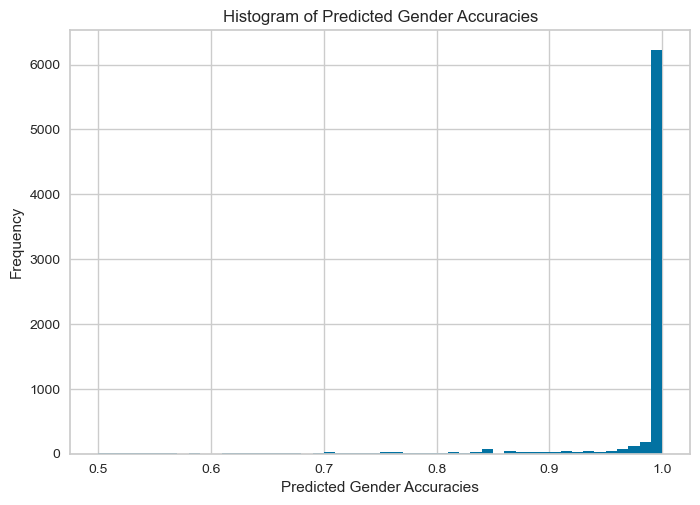

In [47]:
# Histogram of recorded accuracies for each predicted gender
pop_df_complete['Accuracy'].plot.hist(bins=50)
plt.title('Histogram of Predicted Gender Accuracies')
plt.xlabel('Predicted Gender Accuracies')

It's great to see that most of the recorded accuracies are very high. It's also important to remember that these estimated accuracies may not accurately represent how correct the predictions are. One reason for this is that for the nltk classifier, the training data was not very representative of the data that needed predictions.

In [48]:
pop_df_complete[pop_df_complete['Accuracy'] < 0.8].shape[0]/pop_df_complete.shape[0]

0.04051114736269712

In order to ensure that conclusions gathered from this data are more accurate, I will replace the estimated gender with null values for observations with accuracies under 80%. This will only affect around 4% of observations.

In [49]:
pop_df_complete.loc[pop_df_complete['Accuracy'] < 0.8,'Sex at birth'] = ""

Finally, I will export the data to be used to create a Tableau dashboard.

In [50]:
# export dataset
pop_df_complete.to_excel('/Users/jadebouchard/Desktop/ubc_salary_deparment_gender.xlsx')

## Data Visualization

Below is a Tableau dashboard showing a visual representation of the data.
The dashboard can also be accessed through this [link](https://public.tableau.com/views/UBCSalary/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link).

- The top left graph is a histogram of salary, stacked by gender.
- The top right graph is a bar chart of median salaries, split by job title and gender
- The bottom left graph is a circle bar chart of median salaries split by gender and department
- The bottom right graph is a side-by-side box plot of salaries, split by department

You can hover over a portion of a plot to get exact values. In addition, you can filter by title and department on the right side of the dashboard.

In [51]:
%%HTML
<div class='tableauPlaceholder' id='viz1700094097675' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;UB&#47;UBCSalary&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='UBCSalary&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;UB&#47;UBCSalary&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1700094097675');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1120px';vizElement.style.minHeight='587px';vizElement.style.maxHeight='687px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1120px';vizElement.style.minHeight='587px';vizElement.style.maxHeight='687px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='1377px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Conclusion

In summary, I accomplished my main objective of gaining experience in wrangling data and machine learning. In addition, I was able to visualize the data using an interactive Tableau dashboard. This method of presenting the data seems to be much more user-friendly than the PDF that the University of British Columbia provides.

**Data Analysis**

There are many potential conclusions to be derived from the data presented here. This project stops short at the analysis of the data as the primary objective is to wrangle and visualize the data, which has been accomplished. For future work, an analysis on the statistical significance of salary disparity between genders, titles, and departments would be interesting.

If you are interested in seeing demonstrations of my analysis skills, please check out the following projects on GitHub:
</br>[Forest Fire Impact Prediction Using Linear Regression](https://github.com/jjadeb/Stat_301_Project)
</br>[Impact of Internet Access on Final Grade Using the T-Test](https://github.com/jjadeb/stat-201-project)
</br>[Analysis of Celebrity Age of Death using Stratified Sampling](https://github.com/jjadeb/STAT334-Project)

**Data Limitations**

Any conclusions drawn from the data must take into account the inaccuracies of the department, job title, and gender information. This is partly due to the error involved in clustering and natural language classifiers. In addition, we saw there were many missing data-points for department and title information, therefore the data in the visualization may not accurately represent the entirety of the UBC faculty.

**Final Note**

Overall, this project not only advanced my skills in data manipulation and visualization but also laid the groundwork for future in-depth analyses. I also enhanced my understanding around how data collection and cleaning methods can lead to data limitations, impacting the ability to make meaningful conclusions during analysis.